##  <h1><center><font color = '#0080ff'>Time-Series Forecasting on the S&P 500 using RNN </font></center></h1>

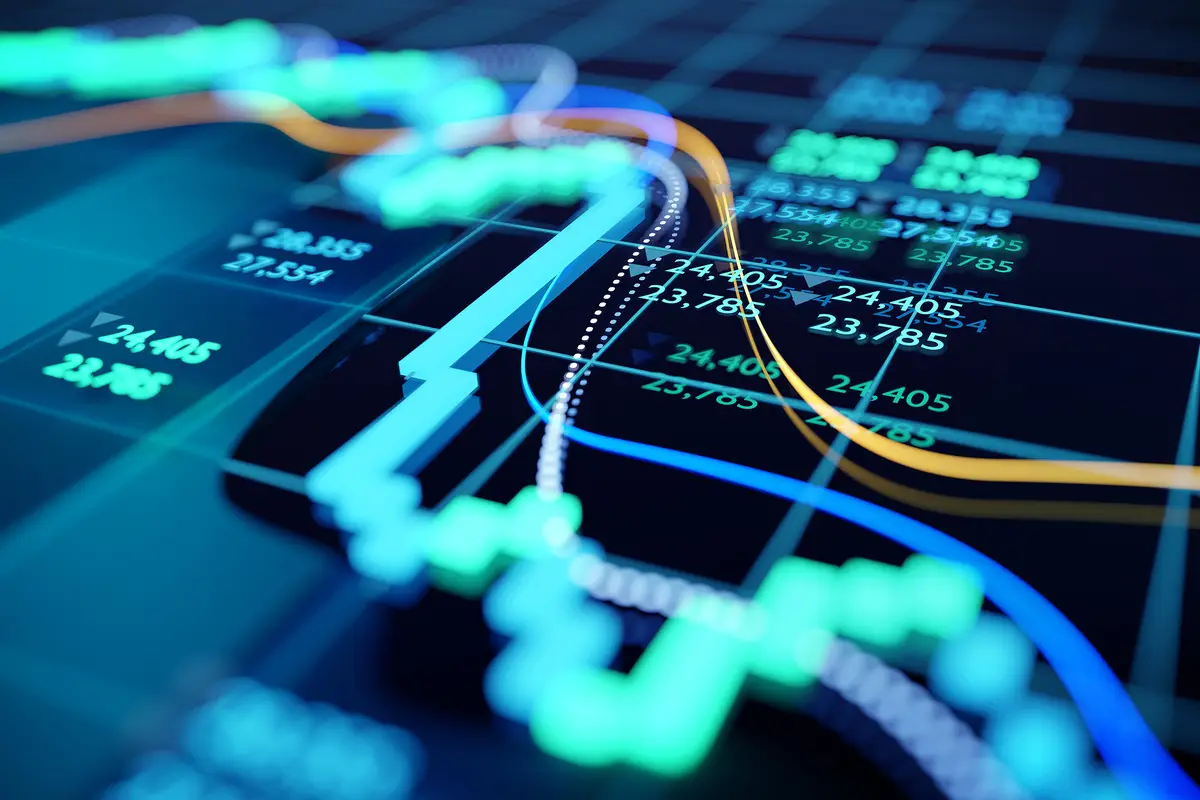

## 1.Context

**. Stocks and financial instrument trading is a lucrative proposition. Stock markets across the world facilitate such trades and thus wealth exchanges hands. Stock prices move up and down all the time and having ability to predict its movement has immense potential to make one rich.Stock price prediction has kept people interested from a long time. There are hypothesis like the Efficient Market Hypothesis, which says that it is almost impossible to beat the market consistently and there are others which disagree with it.There are a number of known approaches and new research going on to find the magic formula to make you rich. One of the traditional methods is the time series forecasting. Fundamental analysis is another method where numerous performance ratios are analyzed to assess a given stock. On the emerging front, there are neural networks, genetic algorithms, and ensembling techniques.**

## 2.Goal

**We are working as traders on the S&P 500 futures desk. We have been tasked with building a model to better forecast how this index will move based on its behavior over the past several years. The better our forecast performs, the more effectively and lucratively our desk will be able to trade these futures.**

## 3. About Dataset

**The dataset we will be working with is from Yahoo Finance via Kaggle, and it contains S&P 500 Index prices from 2015 through 2020.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler


## 2. Data Wrangling and Exploration

**First, we will load in the data and inspect it to determine what steps will be required for cleaning and preprocessing.**

In [2]:
data = pd.read_csv('yahoo_stock.csv')

In [3]:
data.shape

(1825, 7)

In [4]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [6]:
data.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


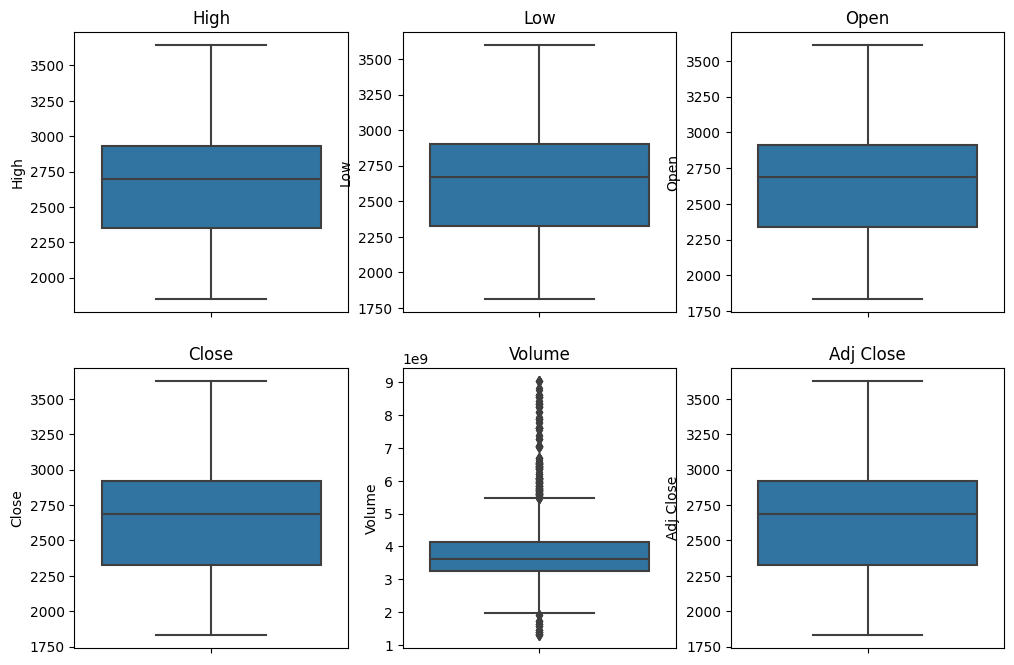

In [8]:
#Outlier Check
plt.figure(figsize = (12,8))
for i,j in zip(range(6),list(data.columns)[1:]):
    plt.subplot(2,3,i+1)
    sns.boxplot(data = data,y = j)
    plt.title(j)
plt.show()

### From the above visualization we can see that there are some outliers present in Volume Column.Let's see how to handle it

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


We can see that the data contains seven columns: `Date`, `High`, `Low`, `Open`, `Close`, `Volume`, and `Adj Close`.

We will want to set the index of the DataFrame to the `Date` column to prepare for time series forecasting, and decide what other column(s) to use for the forecast itself. For now, we are going to use only the `Adj Close` column, which is the closing price of the S&P 500 index, [adjusted for dividends](https://www.investopedia.com/articles/investing/091015/how-dividends-affect-stock-prices.asp). Based on this decision, we modify the DataFrame to drop the other columns.

We should also ensure that the data is sorted by its `Date` column.

In [10]:
#select releavant column and sort the values and set the date as index
stock_data = data[['Date','Adj Close']]
stock_data = stock_data.sort_values('Date')
stock_data = stock_data.set_index('Date')

stock_data.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


In [13]:
stock_data.describe()

,Adj Close
count,1825.000000
mean,2647.856284
std,407.301177
min,1829.079956
25%,2328.949951
50%,2683.340088
75%,2917.520020
max,3626.909912


In [14]:
stock_data.isnull().sum()

Adj Close    0
dtype: int64

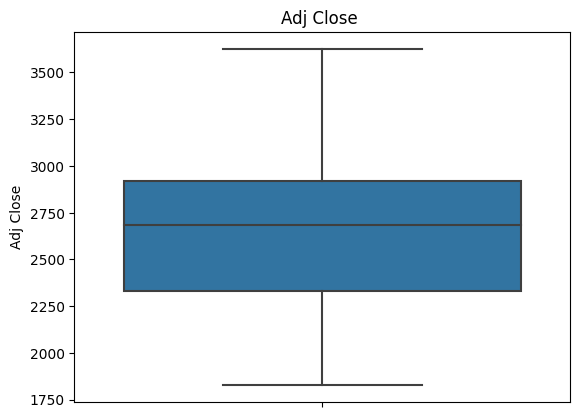

In [17]:
sns.boxplot(data = stock_data,y = 'Adj Close')
plt.title('Adj Close ')
plt.show()

**Great No Missing value in Adj Close column and everything seems to be within reasonable range.From the Boxplot visualization we can say that there are no outliers in Adj Close column.So lets quickly visualize the data.**

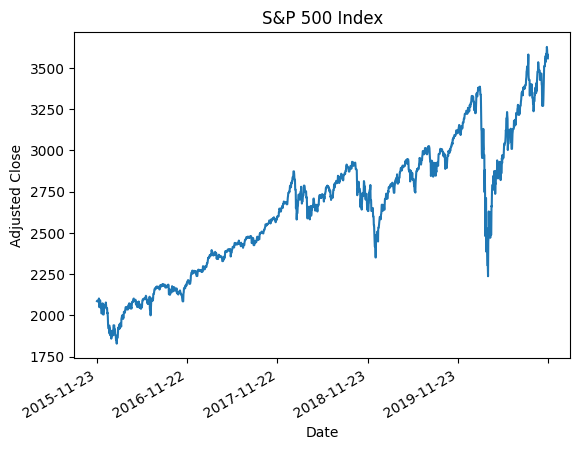

In [18]:
import matplotlib.dates as mdates

# Plot the data
plt.plot(stock_data)

# Add title and axis labels
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.show()

## Data Preprocessing and Data Spliting

In [19]:
train_size = int(len(stock_data)*0.5)
validation_size = int(len(stock_data)*0.25)

train_df= stock_data.iloc[0:train_size,:]
validation_df = stock_data.iloc[train_size:train_size + validation_size,:]
test_df = stock_data.iloc[train_size + validation_size:len(stock_data),:]


#MinMax Scaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train = pd.DataFrame(scaler.transform(train_df),columns = ['Adj Close'],index = train_df.index)
test = pd.DataFrame(scaler.transform(test_df),columns = ['Adj Close'],index = test_df.index)
validation = pd.DataFrame(scaler.transform(validation_df),columns = ['Adj Close'],index = validation_df.index)


**We will also want to shape our data into fixed-length time windows and reshape it into NumPy arrays to prepare it for TensorFlow models.Here we have freedom to modify the window size later so lets reshape our data.**

In [20]:
# Define a helper function to construct windowed datasets
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(i + window_size), 0]
        target = dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Set the desired window size
window_size = 10

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Build and Train a Basic RNN Model

In [21]:
#import libraries
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *

In [22]:
#Build Simple RNN Model
model = Sequential()
model.add(SimpleRNN(32,activation = 'relu',input_shape = (1,window_size)))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3553 (13.88 KB)
Trainable params: 3553 (13.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(X_train,y_train,epochs = 20,validation_data = (X_test,y_test))

Epoch 1/20
29/29 [==============================] - 0s 3ms/step - loss: 2.5466e-04 - val_loss: 0.0023
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: 2.9297e-04 - val_loss: 0.0025
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 2.9610e-04 - val_loss: 0.0022
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: 2.6972e-04 - val_loss: 0.0024
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 2.6021e-04 - val_loss: 0.0023
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: 2.7319e-04 - val_loss: 0.0022
Epoch 7/20
29/29 [==============================] - 0s 3ms/step - loss: 2.6665e-04 - val_loss: 0.0022
Epoch 8/20
29/29 [==============================] - 0s 4ms/step - loss: 2.5288e-04 - val_loss: 0.0022
Epoch 9/20
29/29 [==============================] - 0s 3ms/step - loss: 2.7428e-04 - val_loss: 0.0026
Epoch 10/20
29/29 [==============================] - 0s 3ms/step - loss: 2.6313e-0

In [27]:
#Make Prediction and Evaluate
from sklearn.metrics import r2_score
print(r2_score(y_train,model.predict(X_train)))
print(r2_score(y_test,model.predict(X_test)))

29/29 [==============================] - 0s 1ms/step
0.9961731065317138
14/14 [==============================] - 0s 1ms/step
0.9644725600457589


In [28]:
print(r2_score(y_validation,model.predict(X_validation)))

14/14 [==============================] - 0s 1ms/step
0.965043112899078


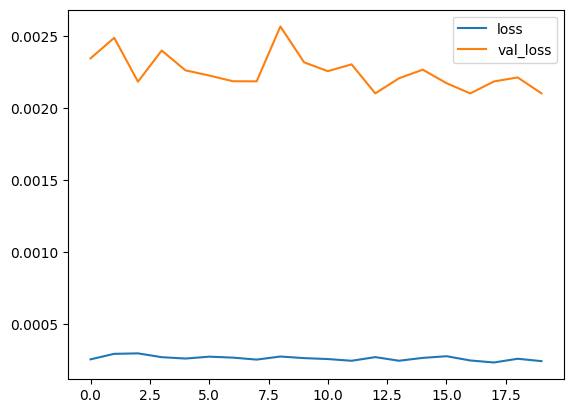

In [29]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

**Hurray!! we got great r2_score value for train,test as well as validation data.Loss and val_loss value which is almost near to zero.Let's see how other model perform compare to SimpleRNN**

## 2. Build and Train an LSTM Model

In [30]:
model1 =Sequential()
model1.add(LSTM(32,activation = 'relu',input_shape = (1,window_size)))
model1.add(Dense(64,activation = 'relu'))
model1.add(Dense(32,activation = 'relu'))
model1.add(Dense(1))

model1.compile(optimizer = 'adam',loss = 'mse')

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5504      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history = model1.fit(X_train,y_train,epochs = 20,validation_data = (X_test,y_test))

Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 0.1103 - val_loss: 0.0075
Epoch 2/20
29/29 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0115
Epoch 3/20
29/29 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0157
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 7.2851e-04 - val_loss: 0.0165
Epoch 6/20
29/29 [==============================] - 0s 6ms/step - loss: 6.4242e-04 - val_loss: 0.0146
Epoch 7/20
29/29 [==============================] - 0s 4ms/step - loss: 5.9532e-04 - val_loss: 0.0148
Epoch 8/20
29/29 [==============================] - 0s 4ms/step - loss: 5.7913e-04 - val_loss: 0.0140
Epoch 9/20
29/29 [==============================] - 0s 4ms/step - loss: 5.7553e-04 - val_loss: 0.0102
Epoch 10/20
29/29 [==============================] - 0s 4ms/step - loss: 5.6801e-04 - val_loss: 0.

In [32]:
from sklearn.metrics import r2_score
print(r2_score(y_train,model1.predict(X_train)))
print(r2_score(y_test,model1.predict(X_test)))

29/29 [==============================] - 0s 1ms/step
0.9908788889023995
14/14 [==============================] - 0s 1ms/step
0.9048283320049342


In [33]:
print(r2_score(y_validation,model1.predict(X_validation)))

14/14 [==============================] - 0s 4ms/step
0.9124513406656243


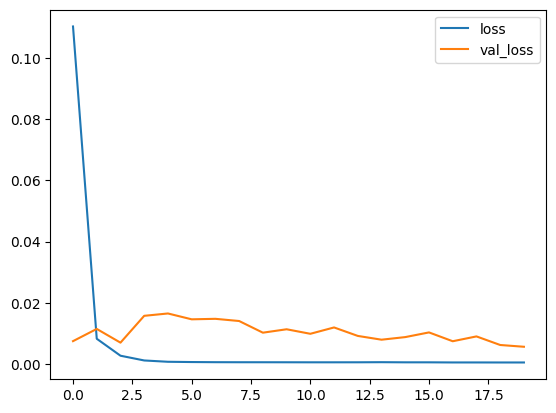

In [34]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

**After moving from Simple RNN to LSTM we got some variance in r2_score value of train,test and validation data.We got loss and val_loss value near to zero.But due to variance in accuracy we will add Convolutional layer and check for the accuracy if it reduce the variance or not.**

## 3. Adding the Convolutional Layer

In [36]:
model2 =Sequential()
model2.add(Conv1D(64,kernel_size = 1,activation = 'relu',input_shape = (1,window_size)))
model2.add(tf.keras.layers.MaxPooling1D(1))
model2.add(LSTM(32,activation = 'relu'))
model2.add(Dense(128,activation = 'relu'))
model2.add(Dense(64,activation = 'relu'))
model2.add(Dense(32,activation = 'relu'))
model2.add(Dense(1))

model2.compile(optimizer = 'adam',loss = 'mse')

model2.summary()

history = model2.fit(X_train,y_train,epochs = 20,validation_data = (X_test,y_test))
print("Training Accuracy : ",r2_score(y_train,model2.predict(X_train)))
print("Testing Accuracy : ",r2_score(y_test,model2.predict(X_test)))
print("Validation Accuracy : ",r2_score(y_validation,model2.predict(X_validation)))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             704       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                      

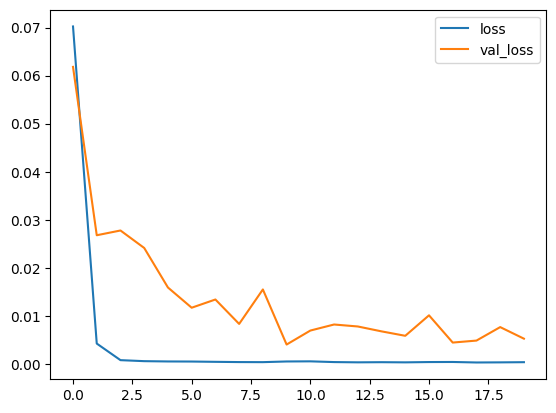

In [37]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

**After adding the convolutional layer we can see there is slightly improvement in accuracy.Lets optimize the model furthur and will examine the loss,val_loss and accuracy gets improve or not.**

## Optimize the model

In [38]:
window_size = 25

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


model3 =Sequential()
model3.add(Conv1D(64,kernel_size = 1,activation = 'relu',input_shape = (1,window_size)))
model3.add(tf.keras.layers.MaxPooling1D(1))
model3.add(LSTM(32,activation = 'relu'))
model3.add(Dense(128,activation = 'relu'))
model3.add(Dense(64,activation = 'relu'))
model3.add(Dense(32,activation = 'relu'))
model3.add(Dense(8,activation = 'relu'))
#model3.add(Dense(4,activation = 'relu'))
model3.add(Dense(1))

model3.compile(optimizer = 'adam',loss = 'mse')

model3.summary()

history = model3.fit(X_train,y_train,epochs = 50,validation_data = (X_test,y_test))
print("Training Accuracy : ",r2_score(y_train,model3.predict(X_train)))
print("Testing Accuracy : ",r2_score(y_test,model3.predict(X_test)))
print("Validation Accuracy : ",r2_score(y_validation,model3.predict(X_validation)))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             1664      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 128)               4224      
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                      

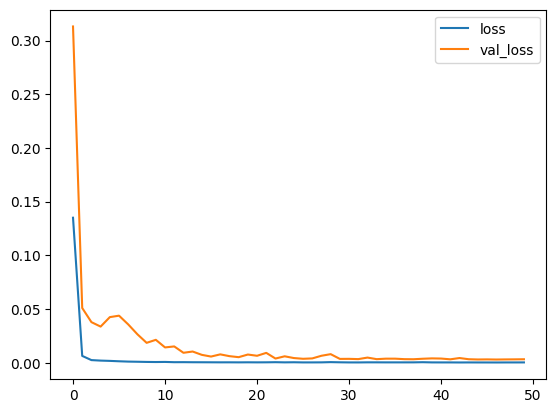

In [39]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

**Overall after optimizing, this is starting to look really good! We are achieving an R-Squared value between 0.94 and 0.99 on the train,test and validation set, which is impressive. As a final performance check, we should now compute and visualize the performance on the testing set.**

## Evaluating the model performance

In [40]:
# Make predictions on all three sets after opti,izing the model
train_pred = model3.predict(X_train)
validation_pred = model3.predict(X_validation)
test_pred = model3.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

14/14 [==============================] - 0s 3ms/step
0.9957195890451185  --> Training Set
0.9479813666121234  --> Validation Set
0.9457677424759403  --> Test Set


**Excellent! The R-Squared value from validation seems to have held up in testing, which is a great sign. Now it's time to visualize this performance. First, we'll need to undo the scaling and windowing preprocessing we've done.**

In [41]:
# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(stock_data), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(stock_data), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(stock_data), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(stock_data) - 1, :] = test_pred

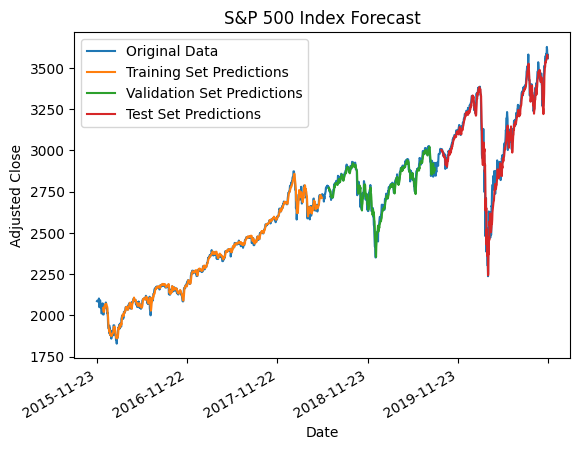

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plot the original data
plt.plot(stock_data, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

## Conclusion:

**Hurray!!The visualization looks as great as the R-Squared suggested it might. The real test, of course, would be to make some predictions for the future and do some trades (or pretend to do some trades — "paper trading" as we call it), then see if we can make any money.**

**Takeaways :** 

**1.We tried different approach including SimpleRNN,LSTM,LSTM with convolutional layer to predict the future Adj Close value.**

**2.The Accuracy and val_accuracy variance is minimum in case SimpleRNN compare to LSTM.But after using the LSTM with convulational layer and some optimizing we get ggod accuracy and val_accuracy for train,test and validation set using LSTM.
So Overall LSTM is giving great result after optimization.**
